In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr

from scipy.optimize import minimize, curve_fit

import importlib

import src.src_offset_sweep_measurement
importlib.reload(src.src_offset_sweep_measurement);

from src.src_offset_sweep_measurement import (OffsetSweepMeasurement, OffsetGainSweepMeasurement, generate_offset_sweep_filename, 
                                              generate_ramp_offset_sweep_filename, generate_ramp_double_jump_gain_sweep_filename, 
                                              generate_ramp_double_jump_offset_sweep_filename, convert_ns_to_samples, convert_samples_to_ns)

I
Q
Qubit_Readout_List
angle
confusion_matrix
expt_samples2
population
population_corrected
readout_list
t_offset
threshold


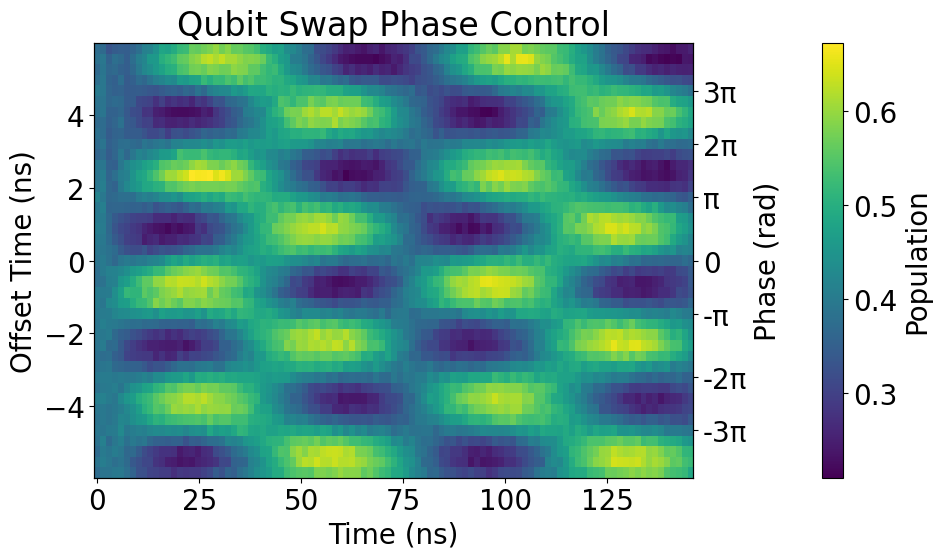

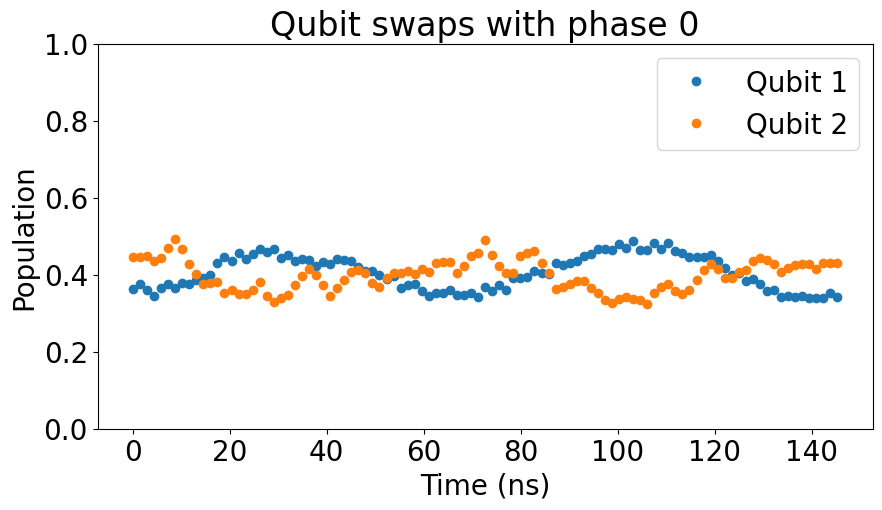

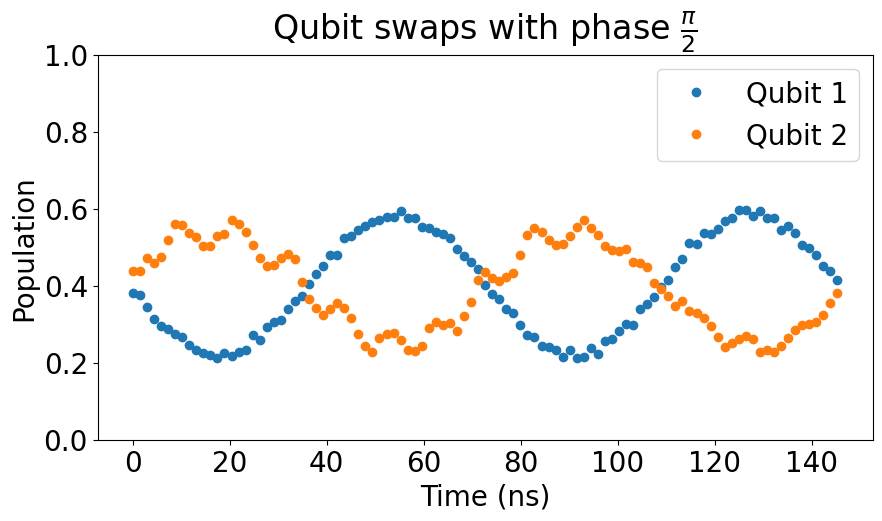

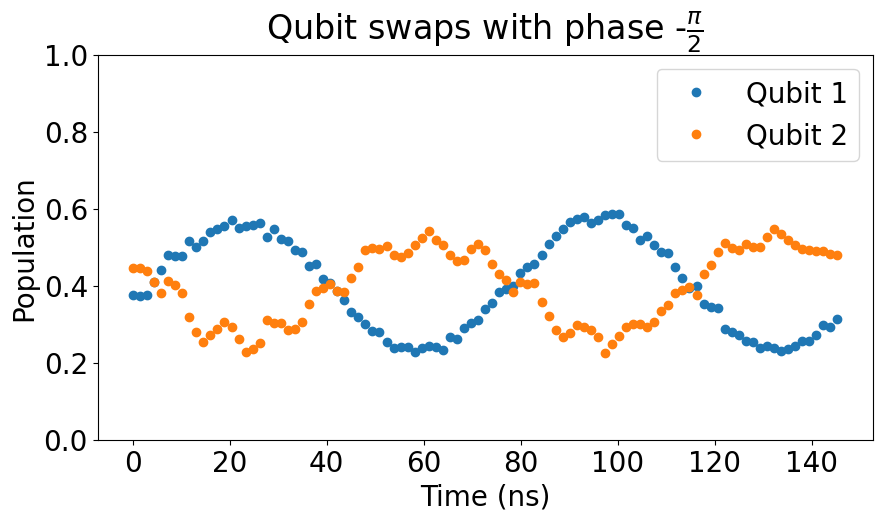

(4, 41, 101)


In [305]:
test_filename = generate_ramp_offset_sweep_filename('2025', '07', '28', '23', '21', '04')

measurement = OffsetSweepMeasurement(test_filename, ramp=True)

measurement.calculate_offset_sin_fit(time_slice_index=12)
measurement.plot_population(corrected=True, readout_indices=0, plot_vs_phase=True, subtitle='Qubit Swap Phase Control')

base_title = 'Qubit swaps with phase '

title = base_title + '0'
measurement.plot_swap_trace(offset_phase_value=0, readout_indices=[0,1], ylim=(0,1), title=title)
title = base_title + r'$\frac{\pi}{2}$'
measurement.plot_swap_trace(offset_phase_value=np.pi/2, readout_indices=[0,1], ylim=(0,1), title=title)
title = base_title + r'-$\frac{\pi}{2}$'
measurement.plot_swap_trace(offset_phase_value=-np.pi/2, readout_indices=[0,1], ylim=(0,1), title=title)

print(measurement.get_population_corrected().shape)


### Fit to Model

Construct model

In [6]:
def create_idle_operator_2Q(a_1, a_2, Delta, t_idle):

    if isinstance(t_idle, (list, np.ndarray)):
        operators = []
        for i in range(len(t_idle)):
            operators.append((-1j * (a_1.dag() * a_1 - a_2.dag() * a_2) * Delta * t_idle[i]).expm())
        return operators

    else:
        return (-1j * (a_1.dag() * a_1 - a_2.dag() * a_2) * Delta * t_idle).expm()

def create_swap_operator_2Q(a_1, a_2, omega, t_swap):
    return (-1j * (a_1.dag() * a_2 + a_2.dag() * a_1) * omega * t_swap).expm()

def create_idle_operator_1Q(a, Delta, t_idle):
    return (-1j * (a.dag() * a) * Delta * t_idle).expm()

def create_swap_operator_1Q(a, omega, t_swap):

    if isinstance(t_swap, (list, np.ndarray)):
        operators = []
        for i in range(len(t_swap)):
            operators.append((-1j * (a.dag() + a) * omega * t_swap[i]).expm())
        return operators
    
    else:
        return (-1j * (a.dag() + a) * omega * t_swap).expm()

In [307]:
def calculate_populations(rho, a, omega, Delta, t_swaps, t_idles):
    # Calculate the populations using the given operators

    # verify rho is a density matrix
    if not (rho.isherm and np.allclose(rho.tr(), 1) and rho.isoper):
        raise ValueError("Input state is not a valid density matrix.")
    
    populations = np.zeros((len(t_idles), len(t_swaps)))

    n = a.dag()*a

    print(n)
    
    
    print(rho)

    for i in range(len(t_idles)):
        U_idle = create_idle_operator_1Q(a, Delta, t_idles[i])
        for j in range(len(t_swaps)):
            U_swap = create_swap_operator_1Q(a, omega, t_swaps[j] - np.abs(t_idles[i]))

            rho_1 = U_idle * rho * U_idle.dag()
            rho_2 = U_swap * rho_1 * U_swap.dag()

            populations[i, j] = qt.expect(n, rho_2)

    return populations  

In [308]:
a = qt.destroy(2)

a_1 = qt.tensor(a, qt.qeye(2))
a_2 = qt.tensor(qt.qeye(2), a)


omega = 5 * 2 * np.pi # MHz
Delta = 300 * 2 * np.pi # MHz

t_swaps = np.linspace(0, 0.2, 101)
t_idles = np.linspace(-0.01, 0.01, 101)


psi0 = qt.basis([2], [0]) + qt.basis([2], [1])
psi0 = psi0.unit()

rho = psi0 * psi0.dag()


populations = calculate_populations(rho, a, omega, Delta, t_swaps, t_idles)

# for i in range(len(t_idles)):
#     populations[i, :] = calculate_populations(rho, a, omega, Delta, t_swaps, t_idles[i])

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]]
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]


KeyboardInterrupt: 

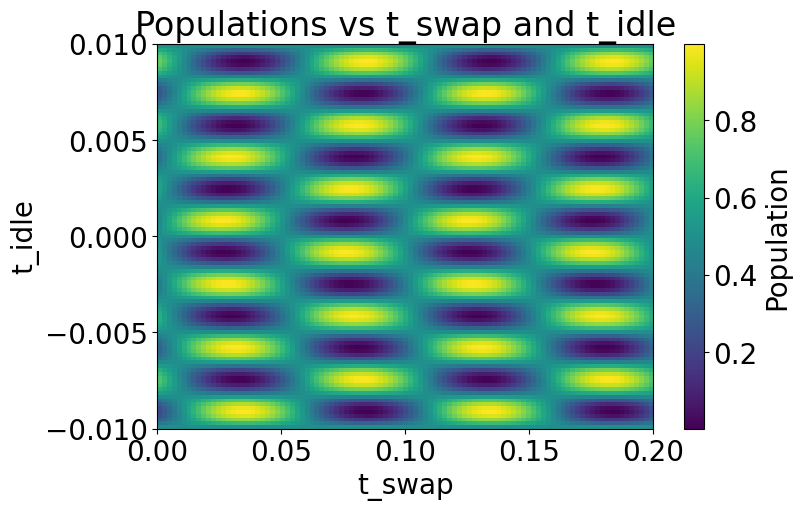

In [ ]:
plt.figure(figsize=(8, 5))
im = plt.imshow(populations, aspect='auto', origin='lower',
                extent=[t_swaps[0], t_swaps[-1], t_idles[0], t_idles[-1]],
                interpolation='none')
plt.colorbar(im, label='Population')
plt.xlabel('t_swap')
plt.ylabel('t_idle')
plt.title('Populations vs t_swap and t_idle')
plt.show()

# 2. Mathematica Expression
Building the two unitaries for each point is too expensive so I want to import the mathematica expression into sympy.

### 2.1 Import Expression into SymPy

In [7]:
### Mathematica string

s = r"""{{(4*J^2 + \[Omega]^2 + Cos[2*J*(Sqrt[tIdle^2] - tSwap)]*(-2*J*mx*\
\[Omega] + mz*\[Omega]^2 + 2*J*(2*J*mz + \
mx*\[Omega])*Cos[tIdle*Sqrt[4*J^2 + \[Omega]^2]] + 2*J*my*Sqrt[4*J^2 \
+ \[Omega]^2]*Sin[tIdle*Sqrt[4*J^2 + \[Omega]^2]]) + \
Sin[2*J*(Sqrt[tIdle^2] - tSwap)]*(-(my*(4*J^2 + \
\[Omega]^2)*Cos[tIdle*Sqrt[4*J^2 + \[Omega]^2]]) + (2*J*mz + mx*\
\[Omega])*Sqrt[4*J^2 + \[Omega]^2]*Sin[tIdle*Sqrt[4*J^2 + \
\[Omega]^2]]))/(2*(4*J^2 + \[Omega]^2)), (2*J*(2*J*mx - mz*\[Omega]) \
+ Cos[tIdle*Sqrt[4*J^2 + \[Omega]^2]]*((-I)*my*(4*J^2 + \
\[Omega]^2)*Cos[2*J*(Sqrt[tIdle^2] - tSwap)] + (2*J*mz + \
mx*\[Omega])*(\[Omega] - (2*I)*J*Sin[2*J*(Sqrt[tIdle^2] - tSwap)])) + \
Sqrt[4*J^2 + \[Omega]^2]*(my*\[Omega] + I*(2*J*mz + \
mx*\[Omega])*Cos[2*J*(Sqrt[tIdle^2] - tSwap)])*Sin[tIdle*Sqrt[4*J^2 + \
\[Omega]^2]] - I*Sin[2*J*(Sqrt[tIdle^2] - tSwap)]*(\[Omega]*(-2*J*mx \
+ mz*\[Omega]) + 2*J*my*Sqrt[4*J^2 + \[Omega]^2]*Sin[tIdle*Sqrt[4*J^2 \
+ \[Omega]^2]]))/(2*(4*J^2 + \[Omega]^2))}, {(2*J*(2*J*mx - mz*\
\[Omega]) + Cos[tIdle*Sqrt[4*J^2 + \[Omega]^2]]*(I*my*(4*J^2 + \
\[Omega]^2)*Cos[2*J*(Sqrt[tIdle^2] - tSwap)] + (2*J*mz + \
mx*\[Omega])*(\[Omega] + (2*I)*J*Sin[2*J*(Sqrt[tIdle^2] - tSwap)])) + \
Sqrt[4*J^2 + \[Omega]^2]*(my*\[Omega] - I*(2*J*mz + \
mx*\[Omega])*Cos[2*J*(Sqrt[tIdle^2] - tSwap)])*Sin[tIdle*Sqrt[4*J^2 + \
\[Omega]^2]] + I*Sin[2*J*(Sqrt[tIdle^2] - tSwap)]*(\[Omega]*(-2*J*mx \
+ mz*\[Omega]) + 2*J*my*Sqrt[4*J^2 + \[Omega]^2]*Sin[tIdle*Sqrt[4*J^2 \
+ \[Omega]^2]]))/(2*(4*J^2 + \[Omega]^2)), (4*J^2 + \[Omega]^2 - \
Cos[2*J*(Sqrt[tIdle^2] - tSwap)]*(-2*J*mx*\[Omega] + mz*\[Omega]^2 + \
2*J*(2*J*mz + mx*\[Omega])*Cos[tIdle*Sqrt[4*J^2 + \[Omega]^2]] + \
2*J*my*Sqrt[4*J^2 + \[Omega]^2]*Sin[tIdle*Sqrt[4*J^2 + \[Omega]^2]]) \
+ Sin[2*J*(Sqrt[tIdle^2] - tSwap)]*(my*(4*J^2 + \
\[Omega]^2)*Cos[tIdle*Sqrt[4*J^2 + \[Omega]^2]] - (2*J*mz + mx*\
\[Omega])*Sqrt[4*J^2 + \[Omega]^2]*Sin[tIdle*Sqrt[4*J^2 + \
\[Omega]^2]]))/(2*(4*J^2 + \[Omega]^2))}}"""

### with tOffset
s = r"""{{(4*J^2 + \[Omega]^2 + Cos[2*J*(Sqrt[(tIdle - tOffset)^2] - \
tSwap)]*(-2*J*mx*\[Omega] + mz*\[Omega]^2 + 2*J*(2*J*mz + \
mx*\[Omega])*Cos[(tIdle - tOffset)*Sqrt[4*J^2 + \[Omega]^2]] + \
2*J*my*Sqrt[4*J^2 + \[Omega]^2]*Sin[(tIdle - tOffset)*Sqrt[4*J^2 + \
\[Omega]^2]]) + Sin[2*J*(Sqrt[(tIdle - tOffset)^2] - \
tSwap)]*(-(my*(4*J^2 + \[Omega]^2)*Cos[(tIdle - tOffset)*Sqrt[4*J^2 + \
\[Omega]^2]]) + (2*J*mz + mx*\[Omega])*Sqrt[4*J^2 + \
\[Omega]^2]*Sin[(tIdle - tOffset)*Sqrt[4*J^2 + \
\[Omega]^2]]))/(2*(4*J^2 + \[Omega]^2)), (2*J*(2*J*mx - mz*\[Omega]) \
+ Cos[(tIdle - tOffset)*Sqrt[4*J^2 + \[Omega]^2]]*((-I)*my*(4*J^2 + \
\[Omega]^2)*Cos[2*J*(Sqrt[(tIdle - tOffset)^2] - tSwap)] + (2*J*mz + \
mx*\[Omega])*(\[Omega] - (2*I)*J*Sin[2*J*(Sqrt[(tIdle - tOffset)^2] - \
tSwap)])) + Sqrt[4*J^2 + \[Omega]^2]*(my*\[Omega] + I*(2*J*mz + mx*\
\[Omega])*Cos[2*J*(Sqrt[(tIdle - tOffset)^2] - tSwap)])*Sin[(tIdle - \
tOffset)*Sqrt[4*J^2 + \[Omega]^2]] - I*Sin[2*J*(Sqrt[(tIdle - \
tOffset)^2] - tSwap)]*(\[Omega]*(-2*J*mx + mz*\[Omega]) + \
2*J*my*Sqrt[4*J^2 + \[Omega]^2]*Sin[(tIdle - tOffset)*Sqrt[4*J^2 + \
\[Omega]^2]]))/(2*(4*J^2 + \[Omega]^2))}, {(2*J*(2*J*mx - \
mz*\[Omega]) + Cos[(tIdle - tOffset)*Sqrt[4*J^2 + \
\[Omega]^2]]*(I*my*(4*J^2 + \[Omega]^2)*Cos[2*J*(Sqrt[(tIdle - \
tOffset)^2] - tSwap)] + (2*J*mz + mx*\[Omega])*(\[Omega] + \
(2*I)*J*Sin[2*J*(Sqrt[(tIdle - tOffset)^2] - tSwap)])) + Sqrt[4*J^2 + \
\[Omega]^2]*(my*\[Omega] - I*(2*J*mz + \
mx*\[Omega])*Cos[2*J*(Sqrt[(tIdle - tOffset)^2] - tSwap)])*Sin[(tIdle \
- tOffset)*Sqrt[4*J^2 + \[Omega]^2]] + I*Sin[2*J*(Sqrt[(tIdle - \
tOffset)^2] - tSwap)]*(\[Omega]*(-2*J*mx + mz*\[Omega]) + \
2*J*my*Sqrt[4*J^2 + \[Omega]^2]*Sin[(tIdle - tOffset)*Sqrt[4*J^2 + \
\[Omega]^2]]))/(2*(4*J^2 + \[Omega]^2)), (4*J^2 + \[Omega]^2 - \
Cos[2*J*(Sqrt[(tIdle - tOffset)^2] - tSwap)]*(-2*J*mx*\[Omega] + mz*\
\[Omega]^2 + 2*J*(2*J*mz + mx*\[Omega])*Cos[(tIdle - \
tOffset)*Sqrt[4*J^2 + \[Omega]^2]] + 2*J*my*Sqrt[4*J^2 + \
\[Omega]^2]*Sin[(tIdle - tOffset)*Sqrt[4*J^2 + \[Omega]^2]]) + \
Sin[2*J*(Sqrt[(tIdle - tOffset)^2] - tSwap)]*(my*(4*J^2 + \
\[Omega]^2)*Cos[(tIdle - tOffset)*Sqrt[4*J^2 + \[Omega]^2]] - (2*J*mz \
+ mx*\[Omega])*Sqrt[4*J^2 + \[Omega]^2]*Sin[(tIdle - \
tOffset)*Sqrt[4*J^2 + \[Omega]^2]]))/(2*(4*J^2 + \[Omega]^2))}}"""

In [8]:
# --- Cleanup replacements ---
replacements = {
    'Cos': 'cos',
    'Sin': 'sin',
    'Sqrt': 'sqrt',
    '^': '**',
    '\\[Omega]': 'omega',
    '[': '(',
    ']': ')',
    r'{{': '[[',
    r'}}': ']]',
    r'}, {': '],['
}

s_replaced = s
for k, v in replacements.items():
    s_replaced = s_replaced.replace(k, v)

print(s_replaced)

[[(4*J**2 + omega**2 + cos(2*J*(sqrt((tIdle - tOffset)**2) - \
tSwap))*(-2*J*mx*omega + mz*omega**2 + 2*J*(2*J*mz + \
mx*omega)*cos((tIdle - tOffset)*sqrt(4*J**2 + omega**2)) + \
2*J*my*sqrt(4*J**2 + omega**2)*sin((tIdle - tOffset)*sqrt(4*J**2 + \
omega**2))) + sin(2*J*(sqrt((tIdle - tOffset)**2) - \
tSwap))*(-(my*(4*J**2 + omega**2)*cos((tIdle - tOffset)*sqrt(4*J**2 + \
omega**2))) + (2*J*mz + mx*omega)*sqrt(4*J**2 + \
omega**2)*sin((tIdle - tOffset)*sqrt(4*J**2 + \
omega**2))))/(2*(4*J**2 + omega**2)), (2*J*(2*J*mx - mz*omega) \
+ cos((tIdle - tOffset)*sqrt(4*J**2 + omega**2))*((-I)*my*(4*J**2 + \
omega**2)*cos(2*J*(sqrt((tIdle - tOffset)**2) - tSwap)) + (2*J*mz + \
mx*omega)*(omega - (2*I)*J*sin(2*J*(sqrt((tIdle - tOffset)**2) - \
tSwap)))) + sqrt(4*J**2 + omega**2)*(my*omega + I*(2*J*mz + mx*\
omega)*cos(2*J*(sqrt((tIdle - tOffset)**2) - tSwap)))*sin((tIdle - \
tOffset)*sqrt(4*J**2 + omega**2)) - I*sin(2*J*(sqrt((tIdle - \
tOffset)**2) - tSwap))*(omega*(-2*J*mx + mz*omega) + \
2*J*

In [9]:


# --- Define symbols you need ---
# J, omega, mx, my, mz, tIdle, tSwap = sp.symbols("J omega mx my mz tIdle tSwap", real=True)
J, omega, mx, my, mz, tIdle, tSwap, tOffset = sp.symbols("J omega mx my mz tIdle tSwap tOffset", real=True)

# --- Tell parse_expr what sin, cos, sqrt mean ---
local_dict = {"sin": sp.sin, "cos": sp.cos, "sqrt": sp.sqrt, "I": sp.I,
              "J": J, "omega": omega, "mx": mx, "my": my, "mz": mz,
              "tIdle": tIdle, "tSwap": tSwap, "tOffset": tOffset}

# --- Parse expression ---
expr = parse_expr(s_replaced, local_dict=local_dict, evaluate=False)

# Wrap as a SymPy Matrix
M = sp.Matrix(expr)

print(M)

mathematica_function = sp.lambdify((J, omega, mx, my, mz, tIdle, tSwap, tOffset), M, "numpy")

print(mathematica_function(J=1, omega=2, mx=0, my=0, mz=1, tIdle=0.01, tSwap=0.05, tOffset=0.02))

def f(J, omega, mx, my, mz, tIdle, tSwap, tOffset):
    
    _tSwap = tSwap
    if _tSwap < abs(tIdle - tOffset):
        _tSwap = abs(tIdle - tOffset)
    # print(J, omega, mx, my, mz, tIdle, _tSwap, tOffset)
    return mathematica_function(J, omega, mx, my, mz, tIdle, _tSwap, tOffset)

def f_gain(J, gain, mx, my, mz, tIdle, tSwap, tOffset, frequency_per_gain):
    omega = gain * frequency_per_gain
    return f(J, omega, mx, my, mz, tIdle, tSwap, tOffset)

Matrix([[(4*J**2 + omega**2 + (-my*(4*J**2 + omega**2)*cos(sqrt(4*J**2 + omega**2)*(tIdle - tOffset)) + sqrt(4*J**2 + omega**2)*(2*J*mz + mx*omega)*sin(sqrt(4*J**2 + omega**2)*(tIdle - tOffset)))*sin(2*J*(-tSwap + sqrt((tIdle - tOffset)**2))) + (-2*J*mx*omega + 2*J*my*sqrt(4*J**2 + omega**2)*sin(sqrt(4*J**2 + omega**2)*(tIdle - tOffset)) + 2*J*(2*J*mz + mx*omega)*cos(sqrt(4*J**2 + omega**2)*(tIdle - tOffset)) + mz*omega**2)*cos(2*J*(-tSwap + sqrt((tIdle - tOffset)**2))))/((2*(4*J**2 + omega**2))), (2*J*(2*J*mx - mz*omega) + sqrt(4*J**2 + omega**2)*(my*omega + I*(2*J*mz + mx*omega)*cos(2*J*(-tSwap + sqrt((tIdle - tOffset)**2))))*sin(sqrt(4*J**2 + omega**2)*(tIdle - tOffset)) + ((-I)*my*(4*J**2 + omega**2)*cos(2*J*(-tSwap + sqrt((tIdle - tOffset)**2))) + (2*J*mz + mx*omega)*(-2*I*J*sin(2*J*(-tSwap + sqrt((tIdle - tOffset)**2))) + omega))*cos(sqrt(4*J**2 + omega**2)*(tIdle - tOffset)) - I*(2*J*my*sqrt(4*J**2 + omega**2)*sin(sqrt(4*J**2 + omega**2)*(tIdle - tOffset)) + omega*(-2*J*mx + mz*

In [10]:
J = 0.005 * 2 * np.pi # GHz
omega = 0.3 * 2 * np.pi # GHz

t_swaps = np.linspace(0, 200, 101)
t_idles = np.linspace(-20, 20, 101)

tOffset = 5

psi0 = qt.basis([2], [0]) + qt.basis([2], [1])
psi0 = psi0.unit()

rho = psi0 * psi0.dag()

# find retangular vector components from spherical coordinates
r = 1
theta = np.pi / 2
phi = 0

mx = r * np.sin(theta) * np.cos(phi)
my = r * np.sin(theta) * np.sin(phi)
mz = r * np.cos(theta)

populations = np.zeros((len(t_idles), len(t_swaps)))

for i in range(len(t_idles)):
    for j in range(len(t_swaps)):
        populations[i, j] = f(J=J, omega=omega, mx=mx, my=my, mz=mz, tIdle=t_idles[i], tSwap=t_swaps[j], tOffset=tOffset).real[0,0]

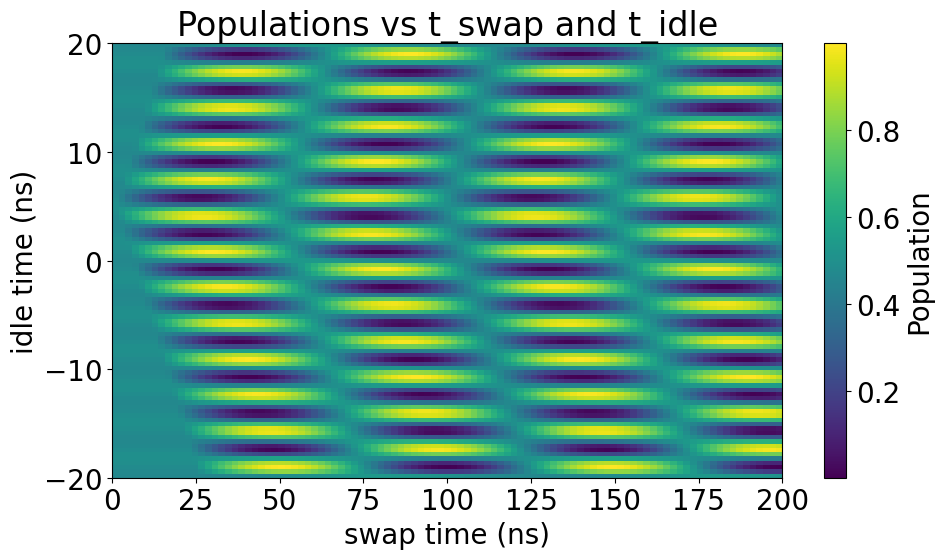

In [ ]:
plt.figure(figsize=(10, 6))
im = plt.imshow(populations, aspect='auto', origin='lower',
                extent=[t_swaps[0], t_swaps[-1], t_idles[0], t_idles[-1]],
                interpolation='none')
plt.colorbar(im, label='Population')
plt.xlabel('swap time (ns)')
plt.ylabel('idle time (ns)')
plt.title('Populations vs t_swap and t_idle')
plt.tight_layout()
plt.show()

# 3. Fit Data

In [11]:
def cost_function(data, simulation):
    return np.sum(np.power(data - simulation, 2))

In [12]:

def fit_offset_sweep(measurement, initial_guess, bounds, fit_params=None, readout_index=0):

    fit_params_all = ['J', 'omega', 'mx', 'my', 'mz', 'tOffset']

    simulation_kwargs = {fit_params_all[i]: initial_guess[i] for i in range(len(fit_params_all))}

    simulation_kwargs['tIdle'] = measurement.get_offset_times()
    simulation_kwargs['tSwap'] = measurement.get_times()

    fit_params_to_index = {param: i for i, param in enumerate(fit_params)}

    if fit_params is None:
        fit_params = fit_params_all

    initial_guess_selected = []
    bounds_selected = []
    for fit_param in fit_params:
        initial_guess_selected.append(initial_guess[fit_params_all.index(fit_param)])
        bounds_selected.append(bounds[fit_params_to_index[fit_param]])

    print(f'initial_guess_selected: {initial_guess_selected}')
    print(f'bounds_selected: {bounds_selected}')

    def create_objective_function(_data, _simulation_kwargs, _fit_params):
        def objective_function(x):
            function_parameters = _simulation_kwargs.copy()
            for fit_param in _fit_params:
                function_parameters[fit_param] = x[fit_params_to_index[fit_param]]

            cost = 0
            for i in range(len(_simulation_kwargs['tIdle'])):
                function_parameters['tIdle'] = _simulation_kwargs['tIdle'][i]
                for j in range(len(_simulation_kwargs['tSwap'])):
                    function_parameters['tSwap'] = _simulation_kwargs['tSwap'][j]
                    cost += (_data[i,j] - f(**function_parameters).real[0,0]) ** 2

            return cost

        return objective_function

    
    

    objective_function = create_objective_function(measurement.get_population_corrected()[readout_index], simulation_kwargs, fit_params)

    result = minimize(objective_function, initial_guess_selected, bounds=bounds_selected)
    
    return result

### 3.1 Offset Fit

I
Q
Qubit_Readout_List
angle
confusion_matrix
expt_samples2
population
population_corrected
readout_list
t_offset
threshold
I
Q
Qubit_Readout_List
angle
confusion_matrix
expt_samples
intermediate_jump_samples
population
population_corrected
readout_list
threshold
I
Q
Qubit_Readout_List
angle
confusion_matrix
expt_samples
intermediate_jump_samples
population
population_corrected
readout_list
threshold
I
Q
Qubit_Readout_List
angle
confusion_matrix
expt_samples
intermediate_jump_samples
population
population_corrected
readout_list
threshold
I
Q
Qubit_Readout_List
angle
confusion_matrix
expt_samples
intermediate_jump_samples
population
population_corrected
readout_list
threshold


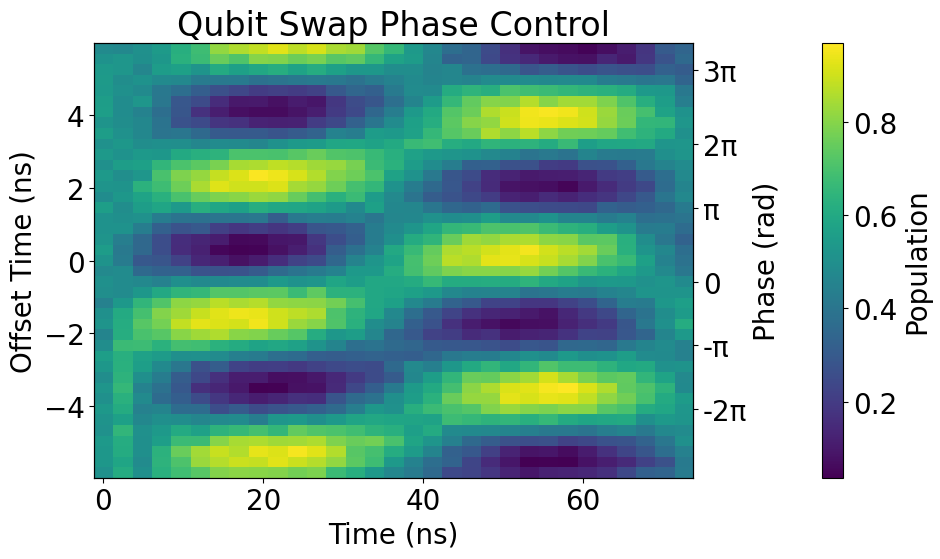

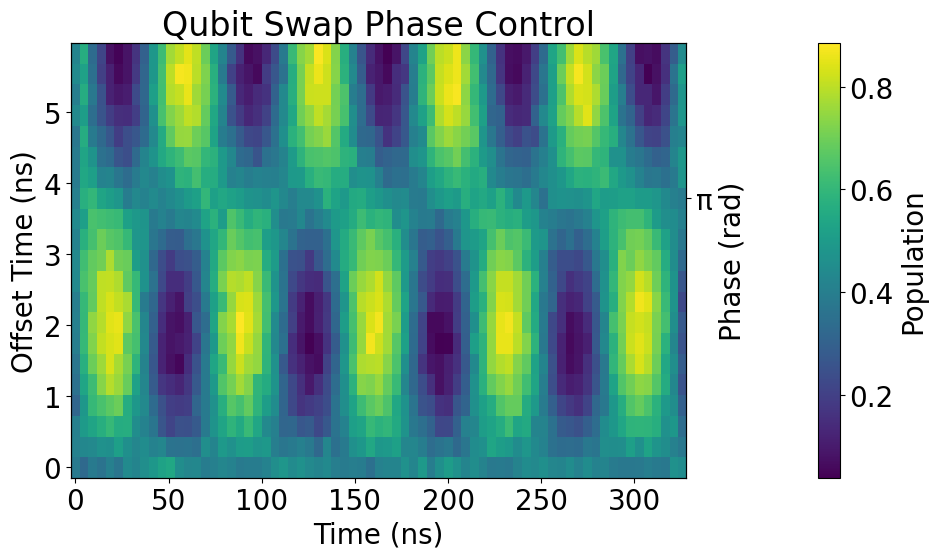

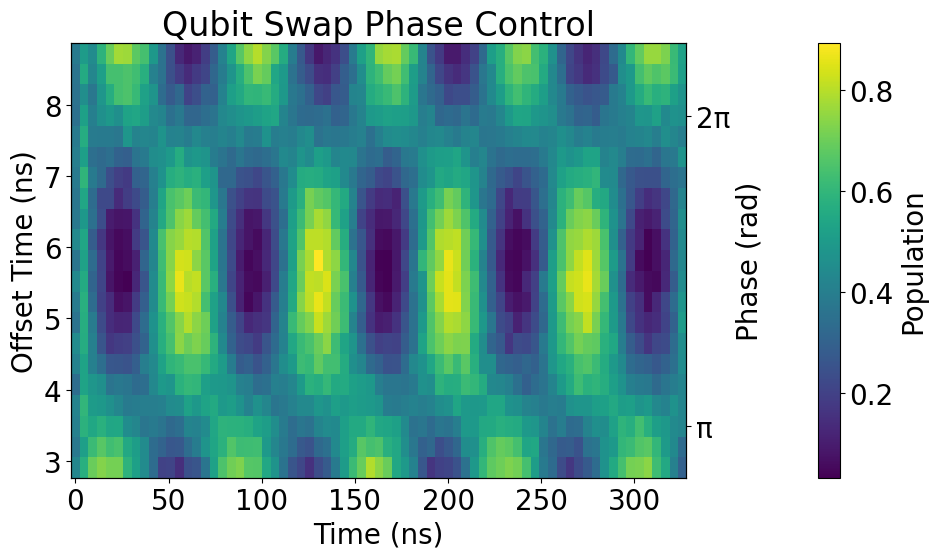

In [ ]:
importlib.reload(src.src_offset_sweep_measurement)
from src.src_offset_sweep_measurement import OffsetSweepMeasurement, OffsetGainSweepMeasurement, generate_offset_sweep_filename, generate_ramp_offset_sweep_filename, generate_ramp_double_jump_gain_sweep_filename, generate_ramp_double_jump_offset_sweep_filename

### offset sweeps
state_to_filename = {}
state_to_measurement = {}


### 8/26/25
# state_to_filename['state_1'] = generate_offset_sweep_filename('2025', '08', '26', '11', '49', '32')

### 8/28/25
state_to_filename['single_jump_offset_sweep'] = generate_ramp_offset_sweep_filename('2025', '08', '28', '13', '54', '35')
state_to_filename['double_jump_offset_sweep'] = generate_ramp_double_jump_offset_sweep_filename('2025', '08', '28', '14', '52', '56')
state_to_filename['double_jump_offset_sweep2'] = generate_ramp_double_jump_offset_sweep_filename('2025', '08', '28', '14', '59', '58')

for state in state_to_filename:
    state_to_measurement[state] = OffsetSweepMeasurement(state_to_filename[state], ramp=False)

    state_to_measurement[state].calculate_offset_sin_fit(time_slice_index=12)
    state_to_measurement[state].plot_population(corrected=True, readout_indices=0, plot_vs_phase=True, subtitle='Qubit Swap Phase Control')



initial guesses
J: 0.04433284166073233
omega: 0.8492923744157833
mx: -0.7954912723815591
my: -0.009413851002269331
mz: -0.03704932785459119
tOffset: 0.09110027754447414
{'J': 0.04433284166073233, 'omega': 0.8492923744157833, 'mx': -0.7954912723815591, 'my': -0.009413851002269331, 'mz': -0.03704932785459119, 'tOffset': 0.09110027754447414}


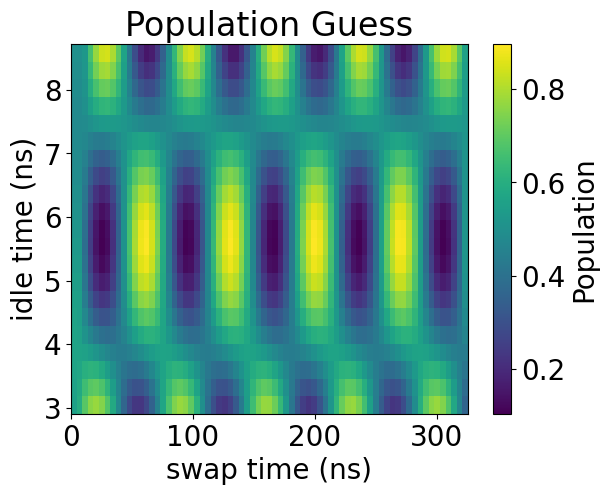

initial cost: 7.763981996171063


In [ ]:
### initial guess

state = 'single_jump_offset_sweep'
state = 'double_jump_offset_sweep2'
measurement = state_to_measurement[state]

fit_params_all = ['J', 'omega', 'mx', 'my', 'mz', 'tOffset']

J = 0.007 * 2 *np.pi
omega = measurement.get_offset_frequency() * 2*np.pi # MHz

mx = 1
my = 0
mz = 0
tOffset = convert_samples_to_ns(-2)


if state == 'single_jump_offset_sweep':
    J = 0.04561049039127065
    omega = 1.6606310194866465
    mx = 0.7740404711841533
    my = -0.4381347591353266
    mz = 0.0373314735521376
    tOffset = -0.36614887918223543


if state == 'double_jump_offset_sweep' or state == 'double_jump_offset_sweep2':
    J = 0.04433284166073233
    omega = 0.8492923744157833
    mx = -0.7954912723815591
    my = -0.009413851002269331
    mz = -0.03704932785459119
    tOffset = 0.09110027754447414

initial_guess = [J, omega, mx, my, mz, tOffset]  # [J (MHz), Omega (MHz), t_offset (ns), mx, my, mz]

fit_params = ['J', 'omega', 'mx', 'my', 'mz', 'tOffset']

J_bounds = np.array([0, 0.01])*2*np.pi
frequency_bounds = np.array([0.1, 0.5])*2*np.pi
m_bounds = np.array([-1, 1])

t_sample_bound = 10
t_offset_bounds = np.array([convert_samples_to_ns(-t_sample_bound), convert_samples_to_ns(t_sample_bound)])

bounds = [J_bounds, frequency_bounds, m_bounds, m_bounds, m_bounds, t_offset_bounds]


print(f'initial guesses')
for i in range(len(fit_params)):
    print(f'{fit_params[i]}: {initial_guess[i]}')


    
t_idles = measurement.get_offset_times()
t_swaps = measurement.get_times()

simulation_kwargs = {fit_params_all[i]: initial_guess[i] for i in range(len(fit_params_all))}

print(simulation_kwargs)

simulation_kwargs['tIdle'] = t_idles
simulation_kwargs['tSwap'] = t_swaps


population_guess = np.zeros((len(t_idles), len(t_swaps)))

function_parameters = simulation_kwargs.copy()

for i in range(len(t_idles)):
    function_parameters['tIdle'] = t_idles[i]
    for j in range(len(t_swaps)):
        function_parameters['tSwap'] = t_swaps[j]
        population_guess[i, j] = f(**function_parameters).real[0, 0]


plt.imshow(population_guess, aspect='auto', origin='lower', interpolation='none',
           extent=[t_swaps[0], t_swaps[-1], t_idles[0], t_idles[-1]])
plt.colorbar(label='Population')
plt.xlabel('swap time (ns)')
plt.ylabel('idle time (ns)')
plt.title('Population Guess')


plt.show()

print(f'initial cost: {np.sum(np.power(population_guess - measurement.get_population_corrected()[0], 2))}')

In [ ]:

result = fit_offset_sweep(measurement, initial_guess, bounds, fit_params) 

print(result)

for i in range(len(fit_params)):
    print(f'{fit_params[i]} = {result.x[i]}')

initial_guess_selected: [0.04433284166073233, 0.8492923744157833, -0.7954912723815591, -0.009413851002269331, -0.03704932785459119, 0.09110027754447414]
bounds_selected: [array([0.        , 0.06283185]), array([0.62831853, 3.14159265]), array([-2.9064375,  2.9064375]), array([-1,  1]), array([-1,  1]), array([-1,  1])]
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 7.309549332902587
        x: [ 4.430e-02  8.161e-01 -8.210e-01  6.889e-02 -4.785e-02
             3.463e-02]
      nit: 35
      jac: [ 2.174e-02  5.637e-04  7.817e-04  8.591e-03  3.670e-04
             1.130e-02]
     nfev: 322
     njev: 46
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
J = 0.04429837916982835
omega = 0.8160503822806794
mx = -0.8210308189408685
my = 0.06888525582922536
mz = -0.04784930709519193
tOffset = 0.0346317564916084
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 7.309549332902587
        

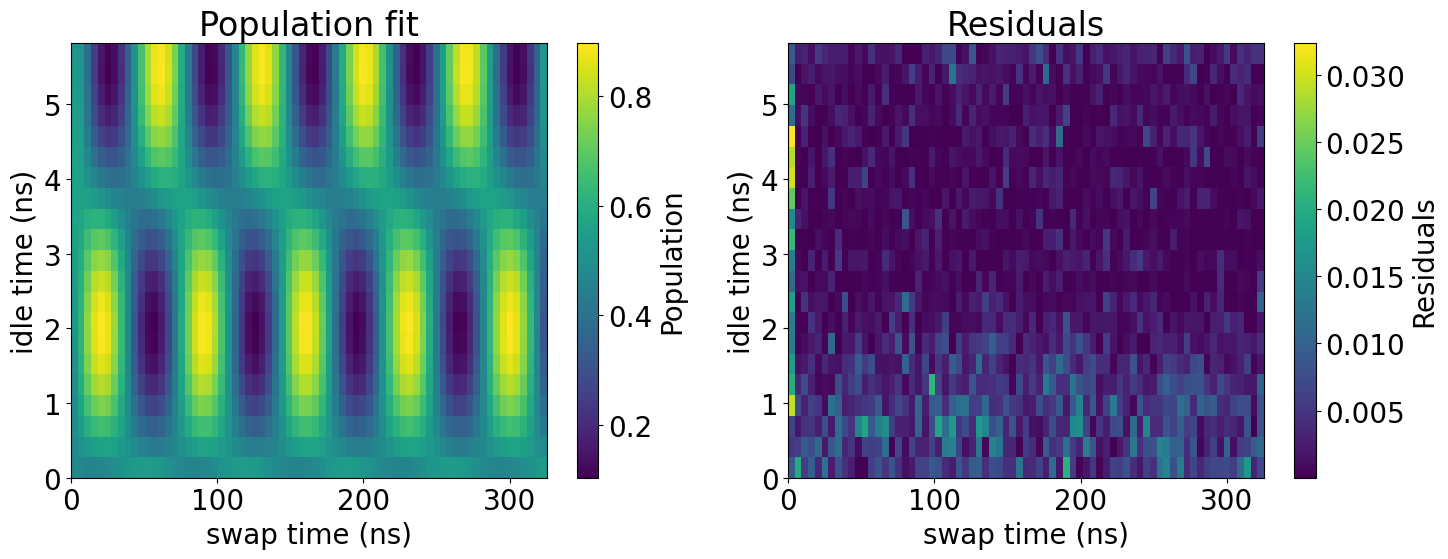

In [ ]:
### fit

simulation_kwargs = {fit_params_all[i]: result.x[i] for i in range(len(fit_params_all))}


simulation_kwargs['tIdle'] = measurement.get_offset_times()
simulation_kwargs['tSwap'] = measurement.get_times()

population_fit = np.zeros((len(t_idles), len(t_swaps)))

function_parameters = simulation_kwargs.copy()

for i in range(len(t_idles)):
    function_parameters['tIdle'] = t_idles[i]
    for j in range(len(t_swaps)):
        function_parameters['tSwap'] = t_swaps[j]
        population_fit[i, j] = f(**function_parameters).real[0, 0]

# Get population data for residuals calculation
population = measurement.get_population_corrected()[0]
residuals = np.power(population - population_fit, 2)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot population fit
im1 = ax1.imshow(population_fit, aspect='auto', origin='lower', interpolation='none',
                 extent=[t_swaps[0], t_swaps[-1], t_idles[0], t_idles[-1]])
cbar1 = plt.colorbar(im1, ax=ax1, label='Population')
ax1.set_xlabel('swap time (ns)')
ax1.set_ylabel('idle time (ns)')
ax1.set_title('Population fit')

# Plot residuals
im2 = ax2.imshow(residuals, aspect='auto', origin='lower', interpolation='none',
                 extent=[t_swaps[0], t_swaps[-1], t_idles[0], t_idles[-1]])
cbar2 = plt.colorbar(im2, ax=ax2, label='Residuals')
ax2.set_xlabel('swap time (ns)')
ax2.set_ylabel('idle time (ns)')
ax2.set_title('Residuals')

plt.tight_layout()
plt.show()

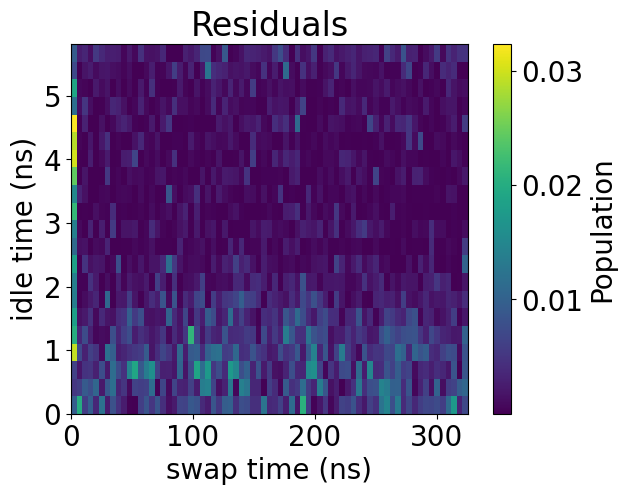

In [ ]:
population = measurement.get_population_corrected()[0]

residuals = np.power(population - population_fit, 2)


plt.imshow(residuals, aspect='auto', origin='lower', interpolation='none',
           extent=[t_swaps[0], t_swaps[-1], t_idles[0], t_idles[-1]])
plt.colorbar(label='Population')
plt.xlabel('swap time (ns)')
plt.ylabel('idle time (ns)')
plt.title('Residuals')


plt.show()

total offset time: 3.804104427071568 ns
total offset time samples: 13.088547154623377


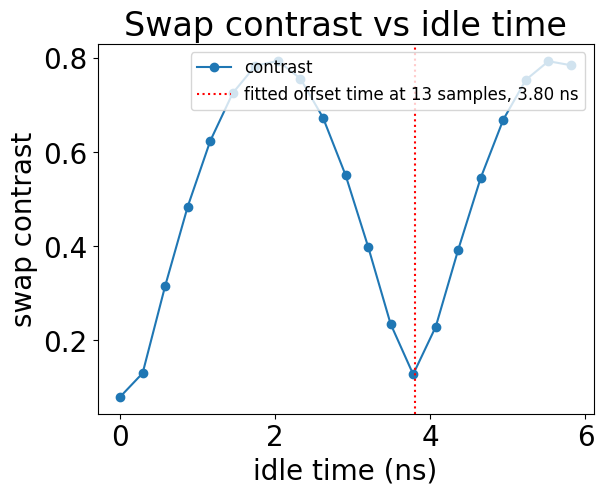

In [ ]:
### analyze fit

J = function_parameters['J']
omega = function_parameters['omega']
mx = function_parameters['mx']
my = function_parameters['my']
mz = function_parameters['mz']
tOffset = function_parameters['tOffset']

expected_mx = 1
expected_my = 0

# sometimes we have to shift by a full period
n_periods = 1

# Solving for phi using atan2:
phi = np.arctan2(expected_my * mx + expected_mx * my, 
                 expected_mx * mx + expected_my * my) + n_periods*2*np.pi

total_offset_time = phi/omega + tOffset
total_offset_time_samples = convert_ns_to_samples(total_offset_time)
print(f'total offset time: {total_offset_time} ns')
print(f'total offset time samples: {total_offset_time_samples}')


contrasts = np.zeros(len(t_idles))
for i in range(len(t_idles)):
    contrasts[i] = np.max(population_fit[i, :]) - np.min(population_fit[i, :])

plt.plot(t_idles, contrasts, linestyle='-', marker='o', label='contrast')
plt.xlabel('idle time (ns)')
plt.ylabel('swap contrast')

plt.axvline(total_offset_time, label=f'fitted offset time at {int(total_offset_time_samples)} samples, {total_offset_time:.2f} ns', linestyle=':', color='red')

plt.title('Swap contrast vs idle time')
plt.legend(fontsize=12, loc='upper right')
plt.show()




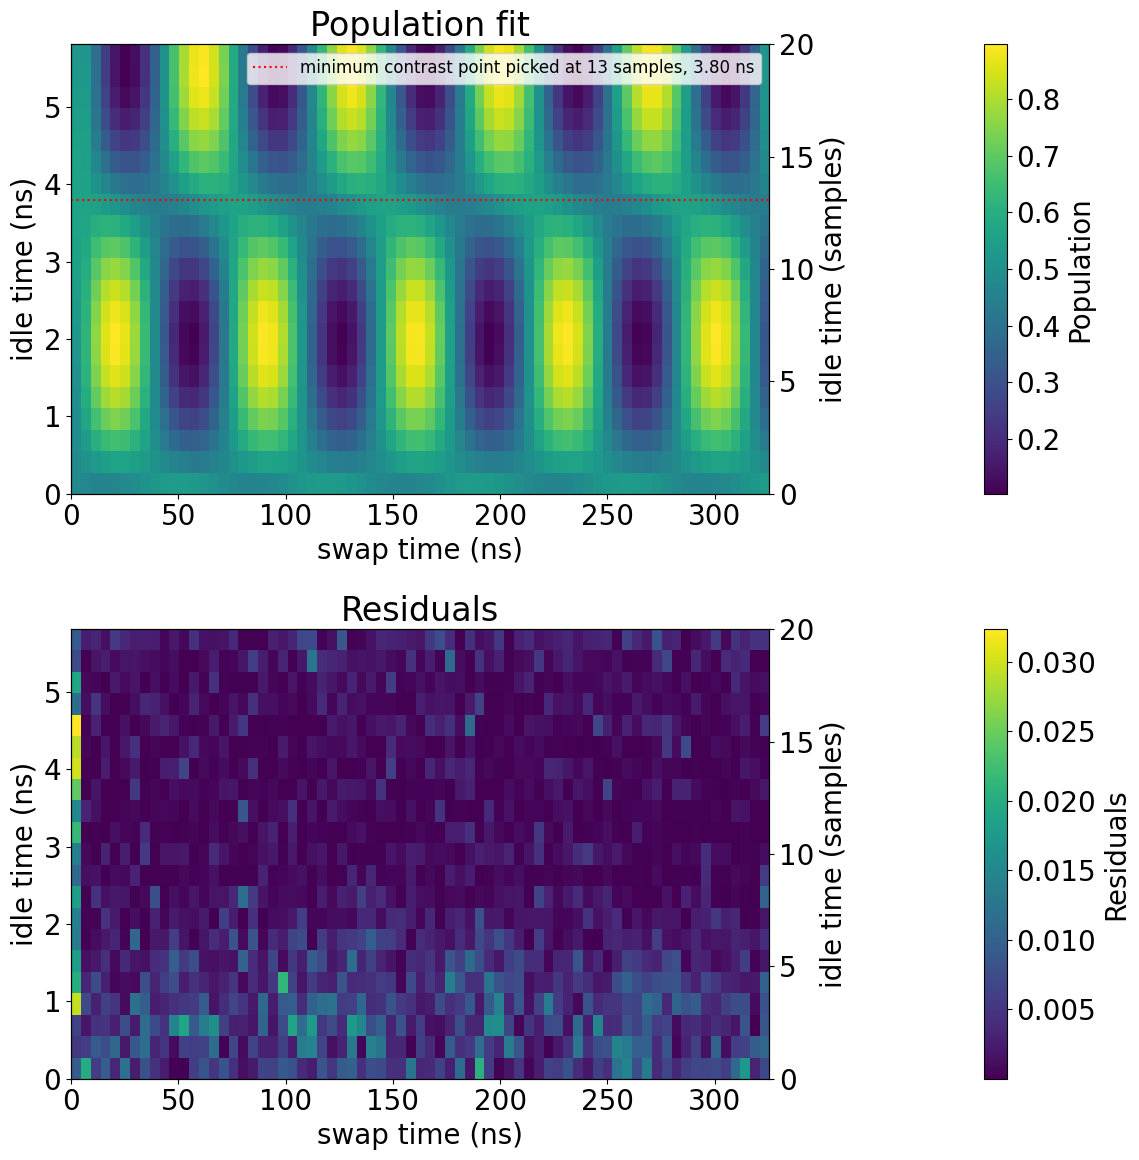

In [ ]:
### fit and residuals

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot population fit
im1 = ax1.imshow(population_fit, aspect='auto', origin='lower', interpolation='none',
                 extent=[t_swaps[0], t_swaps[-1], t_idles[0], t_idles[-1]])

                


pad = 0.2
cbar1 = plt.colorbar(im1, ax=ax1, label='Population', pad=pad)

ax1.set_xlabel('swap time (ns)')
ax1.set_ylabel('idle time (ns)')
ax1.set_title('Population fit')

ax1.axhline(total_offset_time, linestyle=':', color='red', label=f'minimum contrast point picked at {int(total_offset_time_samples)} samples, {total_offset_time:.2f} ns')
ax1.legend(fontsize=12)

# Add secondary y-axis for ax1 with sample labels
ax1_twin = ax1.twinx()
max_samples = abs(convert_ns_to_samples(np.max(t_idles)))
tick_labels = np.arange(-max_samples, max_samples + 1, 5)
tick_locations = [convert_samples_to_ns(label) for label in tick_labels]
ax1_twin.set_yticks(tick_locations)
ax1_twin.set_yticklabels([int(label) for label in tick_labels])
ax1_twin.set_ylabel('idle time (samples)')
ax1_twin.set_ylim(ax1.get_ylim())

# Plot residuals
im2 = ax2.imshow(residuals, aspect='auto', origin='lower', interpolation='none',
                 extent=[t_swaps[0], t_swaps[-1], t_idles[0], t_idles[-1]])
cbar2 = plt.colorbar(im2, ax=ax2, label='Residuals', pad=pad)
ax2.set_xlabel('swap time (ns)')
ax2.set_ylabel('idle time (ns)')
ax2.set_title('Residuals')

# Add secondary y-axis for ax2 with sample labels
ax2_twin = ax2.twinx()
ax2_twin.set_yticks(tick_locations)
ax2_twin.set_yticklabels([int(label) for label in tick_labels])
ax2_twin.set_ylabel('idle time (samples)')
ax2_twin.set_ylim(ax2.get_ylim())

plt.tight_layout()
plt.show()

### 3.2 Gain Sweep

In [2]:

def fit_gain_sweep(measurement, initial_guess, bounds, gain_start, fit_params=None, readout_index=0):

    fit_params_all = ['J', 'tIdle', 'mx', 'my', 'mz', 'tOffset', 'frequency_per_gain']

    simulation_kwargs = {fit_params_all[i]: initial_guess[i] for i in range(len(fit_params_all))}

    # simulation_kwargs['omega'] = omega_sweep
    simulation_kwargs['gain'] = measurement.get_ff_gains()
    simulation_kwargs['tSwap'] = measurement.get_times()

    fit_params_to_index = {param: i for i, param in enumerate(fit_params)}

    if fit_params is None:
        fit_params = fit_params_all

    initial_guess_selected = []

    bounds_selected = []
    for fit_param in fit_params:
        initial_guess_selected.append(initial_guess[fit_params_all.index(fit_param)])
        bounds_selected.append(bounds[fit_params_all.index(fit_param)])

    print(f'initial_guess_selected: {initial_guess_selected}')
    print(f'bounds selected: {bounds_selected}')

    def create_objective_function(_data, _simulation_kwargs, _fit_params):
        def objective_function(x):
            function_parameters = _simulation_kwargs.copy()
            for fit_param in _fit_params:
                function_parameters[fit_param] = x[fit_params_to_index[fit_param]]
            cost = 0
            for i in range(len(_simulation_kwargs['gain'])):
                function_parameters['gain'] = _simulation_kwargs['gain'][i] - gain_start
                for j in range(len(_simulation_kwargs['tSwap'])):
                    function_parameters['tSwap'] = _simulation_kwargs['tSwap'][j]
                    cost += (_data[i,j] - f_gain(**function_parameters).real[0,0]) ** 2
            return cost

        return objective_function


    objective_function = create_objective_function(measurement.get_population_corrected()[readout_index], simulation_kwargs, fit_params)

    result = minimize(objective_function, initial_guess_selected, bounds=bounds_selected)
    
    return result

I
Q
Qubit_Readout_List
angle
confusion_matrix
expt_samples
intermediate_jump_gains
population
population_corrected
readout_list
threshold
I
Q
Qubit_Readout_List
angle
confusion_matrix
expt_samples
intermediate_jump_gains
population
population_corrected
readout_list
threshold


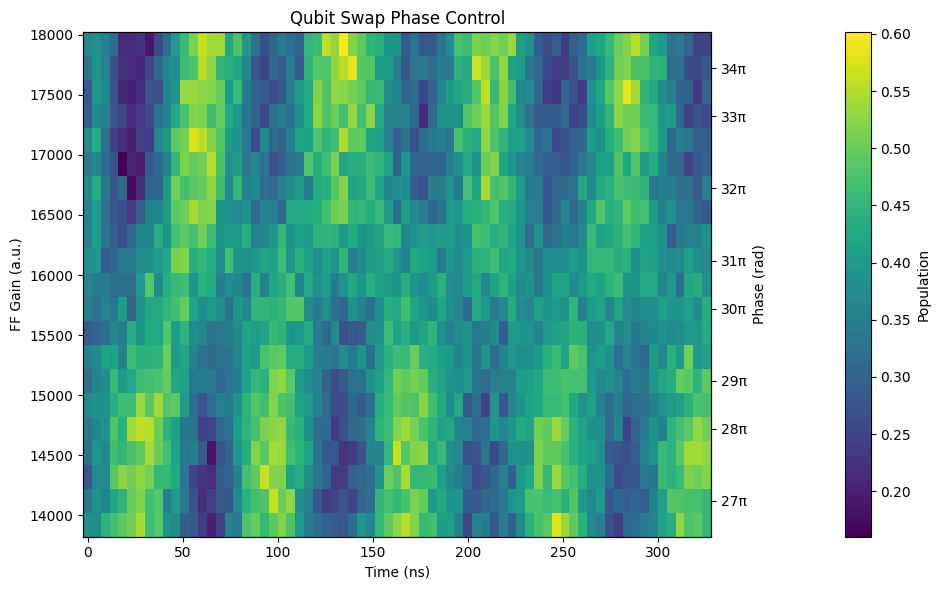

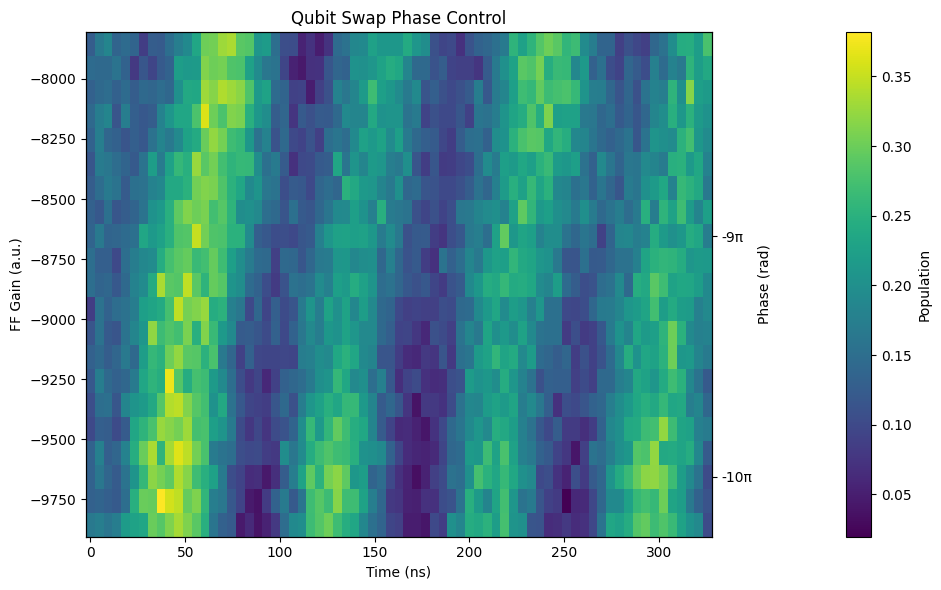

In [167]:
importlib.reload(src.src_offset_sweep_measurement)
from src.src_offset_sweep_measurement import OffsetSweepMeasurement, OffsetGainSweepMeasurement, generate_offset_sweep_filename, generate_ramp_offset_sweep_filename, generate_ramp_double_jump_gain_sweep_filename, generate_ramp_double_jump_offset_sweep_filename

### offset sweeps
state_to_filename = {}
state_to_measurement = {}


### 8/26/25
# state_to_filename['state_1'] = generate_offset_sweep_filename('2025', '08', '26', '11', '49', '32')

### 8/28/25
# state_to_filename['double_jump_gain_sweep'] = generate_ramp_double_jump_gain_sweep_filename('2025', '08', '28', '15', '24', '57')
# state_to_filename['double_jump_gain_sweep2'] = generate_ramp_double_jump_gain_sweep_filename('2025', '08', '28', '22', '35', '53')

### 8/29/25
# state_to_filename['double_jump_gain_sweep'] = generate_ramp_double_jump_gain_sweep_filename('2025', '08', '29', '13', '47', '29')
# state_to_filename['double_jump_gain_sweep2'] = generate_ramp_double_jump_gain_sweep_filename('2025', '08', '29', '14', '47', '46')

### 9/4/25
# state_to_filename['double_jump_gain_sweep'] = generate_ramp_double_jump_gain_sweep_filename('2025', '09', '04', '14', '51', '40')
# state_to_filename['double_jump_gain_sweep2'] = generate_ramp_double_jump_gain_sweep_filename('2025', '09', '04', '15', '51', '06')
# state_to_filename['double_jump_gain_sweep2'] = generate_ramp_double_jump_gain_sweep_filename('2025', '09', '04', '16', '44', '31')

### 9/5/25
state_to_filename['double_jump_gain_sweep'] = generate_ramp_double_jump_gain_sweep_filename('2025', '09', '05', '14', '45', '10')
state_to_filename['double_jump_gain_sweep2'] = generate_ramp_double_jump_gain_sweep_filename('2025', '09', '05', '15', '45', '37')

### 9/6/25
state_to_filename['double_jump_gain_sweep'] = generate_ramp_double_jump_gain_sweep_filename('2025', '09', '06', '11', '40', '51')
state_to_filename['double_jump_gain_sweep2'] = generate_ramp_double_jump_gain_sweep_filename('2025', '09', '06', '11', '58', '12')


state_to_readout_indices = {
    'double_jump_gain_sweep': 0,
    'double_jump_gain_sweep2': 0
}

for state in state_to_filename:
    state_to_measurement[state] = OffsetGainSweepMeasurement(state_to_filename[state], ramp=False)

    state_to_measurement[state].plot_population(corrected=True, readout_indices=state_to_readout_indices[state], plot_vs_phase=True, subtitle='Qubit Swap Phase Control')



tIdle: 4.0690124999999995
initial guesses
J: 0.036939687976219694
mx: -0.4416574438970015
my: -0.47297877189476284
mz: -0.11551087190983927
tOffset: -3.3115856833452955
frequency_per_gain: 0.00015707963267948965
{'J': 0.036939687976219694, 'tIdle': 9.8818875, 'mx': -0.4416574438970015, 'my': -0.47297877189476284, 'mz': -0.11551087190983927, 'tOffset': -3.3115856833452955, 'frequency_per_gain': 0.00015707963267948965}
0.16541170755404427


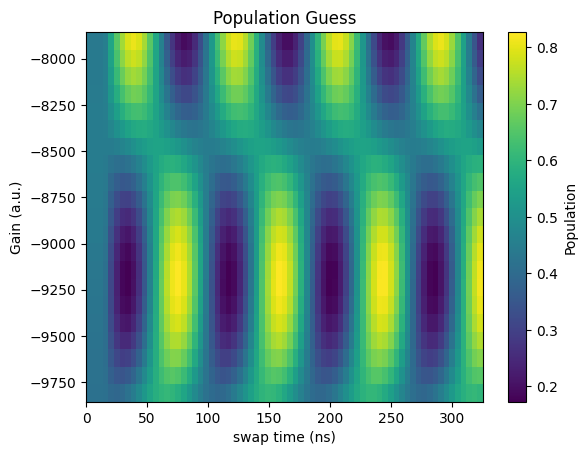

initial cost: 201.3978021087686


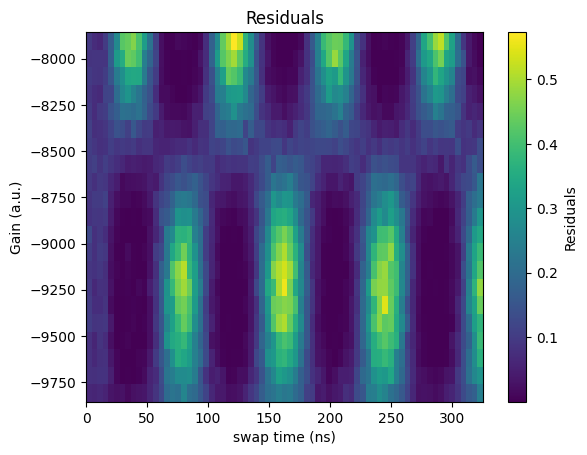

In [168]:
### initial guess

state = 'double_jump_gain_sweep2'
measurement = state_to_measurement[state]

fit_params_all = ['J', 'tIdle', 'mx', 'my', 'mz', 'tOffset', 'frequency_per_gain']


J = 0.007 * 2 *np.pi
tIdle = measurement.get_offset_time() # ns

# tIdle is in units of ns * GHz/(dac units) = 1/(dac units)
dac_per_GHz = 4000/0.1
tIdle = tIdle * dac_per_GHz
    
ff_gains = measurement.get_ff_gains()
t_swaps = measurement.get_times()




tIdle = convert_samples_to_ns(14)

print(f'tIdle: {tIdle}')


t_offset = convert_samples_to_ns(1)
mx = 1
my = 0
mz = 0

if state == 'double_jump_gain_sweep':
    # sweep Q2

    gain_start = 2580
    omegas = (ff_gains - gain_start) / dac_per_GHz*2*np.pi # GHz

    tIdle = convert_samples_to_ns(26)
    t_offset = convert_samples_to_ns(2)

    J = 0.04398567724252031
    tIdle = 6.416193609574727
    mx = 0.6614556587390866
    my = -0.3998835670437963
    mz = 0.02238610122902616
    tOffset = 0.5956818225217723

    J = 0.043964033186614335
    mx = 0.6780900382165134
    my = -0.3311050459367194
    mz = -0.027863424127501386
    tOffset = 0.8383215697725015
    frequency_per_gain = 0.00016515457451117595

    # 9/4/25
    J = 0.043964033186614335
    mx = 0.6780900382165134
    my = -0.3311050459367194
    mz = -0.2
    tIdle = convert_samples_to_ns(23)
    tOffset = convert_samples_to_ns(2)
    frequency_per_gain = 0.00016515457451117595

    J = 0.04366152021210902
    mx = 0.6853338821775627
    my = -0.30115247447058957
    mz = -0.1729805469608589
    tOffset = 0.6990110391392378
    frequency_per_gain = 0.00015226153668446767

    # 9/6/25
    gain_start = 66

if state == 'double_jump_gain_sweep2':
    # sweep Q4
    gain_start = 2475
    omegas = (ff_gains - gain_start) / dac_per_GHz*2*np.pi # GHz

    J = 0.006 * 2 *np.pi
    mx = -1
    my = 0
    mz = 0

    tIdle = convert_samples_to_ns(24)
    t_offset = convert_samples_to_ns(-13)

    # J = 0.0
    # tIdle = 10.788329806947988
    # mx = 1.0
    # my = -1.0
    # mz = -0.9710375564365327
    # tOffset = -5.812875

    # 9/4/25
    tIdle = convert_samples_to_ns(34)
    t_offset = convert_samples_to_ns(11)

    # J = 0.04366152021210902
    mx = 0.6853338821775627
    my = -0.30115247447058957
    mz = -0.1729805469608589
    frequency_per_gain = 0.00015226153668446767

    J = 0.036939687976219694
    mx = -0.4416574438970015
    my = -0.47297877189476284
    mz = -0.11551087190983927
    tOffset = -3.3115856833452955
    frequency_per_gain = 7.853981633974483e-05

    # 9/5/25
    gain_start = -701

    # 9/6/25
    gain_start = 240


    
t_offset = tOffset

frequency_per_gain = 2*np.pi/dac_per_GHz

initial_guess = [J, tIdle, mx, my, mz, t_offset, frequency_per_gain]  # [J (MHz), Omega (MHz), t_offset (ns), mx, my, mz]

fit_params = ['J', 'tIdle', 'mx', 'my', 'mz', 'tOffset']
fit_params = ['J', 'mx', 'my', 'mz', 'tOffset', 'frequency_per_gain']

J_bounds = np.array([0, 0.01])*2*np.pi
m_bounds = np.array([-1, 1])

t_idle_bounds = np.array([convert_samples_to_ns(0), convert_samples_to_ns(40)])

t_sample_bound = 20
t_offset_bounds = np.array([convert_samples_to_ns(-t_sample_bound), convert_samples_to_ns(t_sample_bound)])

frequency_ratio_bounds = np.array([0.5*frequency_per_gain, 2*frequency_per_gain])

bounds = [J_bounds, t_idle_bounds, m_bounds, m_bounds, m_bounds, t_offset_bounds, frequency_ratio_bounds]


print(f'initial guesses')
for i in range(len(fit_params)):
    print(f'{fit_params[i]}: {initial_guess[fit_params_all.index(fit_params[i])]}')




simulation_kwargs = {fit_params_all[i]: initial_guess[i] for i in range(len(fit_params_all))}

print(simulation_kwargs)

# simulation_kwargs['omega'] = omegas
simulation_kwargs['tSwap'] = t_swaps

population_guess = np.zeros((len(ff_gains), len(t_swaps)))

function_parameters = simulation_kwargs.copy()
print(measurement.get_population_corrected()[state_to_readout_indices[state]][0,0])


for i in range(len(omegas)):
    function_parameters['gain'] = ff_gains[i] - gain_start
    for j in range(len(t_swaps)):
        function_parameters['tSwap'] = t_swaps[j]
        population_guess[i, j] = f_gain(**function_parameters).real[0, 0]

plt.imshow(population_guess, aspect='auto', origin='lower', interpolation='none',
           extent=[t_swaps[0], t_swaps[-1], ff_gains[0], ff_gains[-1]])
plt.colorbar(label='Population')
plt.xlabel('swap time (ns)')
plt.ylabel('Gain (a.u.)')
plt.title('Population Guess')


plt.show()



print(f'initial cost: {np.sum(np.power(population_guess - measurement.get_population_corrected()[state_to_readout_indices[state]], 2))}')

residuals = np.power(population_guess - measurement.get_population_corrected()[state_to_readout_indices[state]], 2)

plt.imshow(residuals, aspect='auto', origin='lower', interpolation='none',
           extent=[t_swaps[0], t_swaps[-1], ff_gains[0], ff_gains[-1]])
plt.colorbar(label='Residuals')
plt.xlabel('swap time (ns)')
plt.ylabel('Gain (a.u.)')
plt.title('Residuals')



plt.show()



In [40]:

print(f'initial guess: {initial_guess}')
# result = fit_gain_sweep(measurement, initial_guess, bounds, fit_params=fit_params, omega_sweep=omegas, readout_index=state_to_readout_indices[state]) 
result = fit_gain_sweep(measurement, initial_guess, bounds, fit_params=fit_params, gain_start=gain_start, readout_index=state_to_readout_indices[state]) 

print(result)

for i in range(len(fit_params)):
    print(f'{fit_params[i]} = {result.x[i]}')

initial guess: [0.03769911184307752, 9.8818875, 0.6853338821775627, -0.30115247447058957, -0.1729805469608589, 0.6990110391392378, 0.00015707963267948965]
initial_guess_selected: [0.03769911184307752, 0.6853338821775627, -0.30115247447058957, -0.1729805469608589, 0.6990110391392378, 0.00015707963267948965]
bounds selected: [array([0.        , 0.06283185]), array([-1,  1]), array([-1,  1]), array([-1,  1]), array([-5.812875,  5.812875]), array([7.85398163e-05, 3.14159265e-04])]
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18.923721540512236
        x: [ 3.694e-02 -4.417e-01 -4.730e-01 -1.155e-01 -3.312e+00
             7.854e-05]
      nit: 117
      jac: [-9.241e-02  2.380e-05 -2.032e-04 -1.704e-03 -1.876e-04
             1.590e+04]
     nfev: 959
     njev: 137
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
J = 0.036939687976219694
mx = -0.4416574438970015
my = -0.47297877189476284
mz = -0.11551087190983927
tOffset = -3.31

In [21]:
def convert_ff_gain_to_frequency(gain, gain_start):
    return (gain - gain_start) / dac_per_GHz * 2 * np.pi # 2pi GHz

def convert_frequency_to_ff_gain(frequency, gain_start):
    return frequency / (2 * np.pi) * dac_per_GHz + gain_start # 2pi GHz

purity: 0.7683082796424925
{'J': 0.04366152021210902, 'tIdle': 6.684806249999999, 'mx': 0.6853338821775627, 'my': -0.30115247447058957, 'mz': -0.1729805469608589, 'tOffset': 0.6990110391392378, 'frequency_per_gain': 0.00015226153668446767, 'tSwap': array([  0.    ,   4.6503,   9.3006,  13.9509,  18.6012,  23.2515,
        27.9018,  32.5521,  37.2024,  41.8527,  46.503 ,  51.1533,
        55.8036,  60.4539,  65.1042,  69.7545,  74.4048,  79.0551,
        83.7054,  88.3557,  93.006 ,  97.6563, 102.3066, 106.9569,
       111.6072, 116.2575, 120.9078, 125.5581, 130.2084, 134.8587,
       139.509 , 144.1593, 148.8096, 153.4599, 158.1102, 162.7605,
       167.4108, 172.0611, 176.7114, 181.3617, 186.012 , 190.6623,
       195.3126, 199.9629, 204.6132, 209.2635, 213.9138, 218.5641,
       223.2144, 227.8647, 232.515 , 237.1653, 241.8156, 246.4659,
       251.1162, 255.7665, 260.4168, 265.0671, 269.7174, 274.3677,
       279.018 , 283.6683, 288.3186, 292.9689, 297.6192, 302.2695,
       306.919

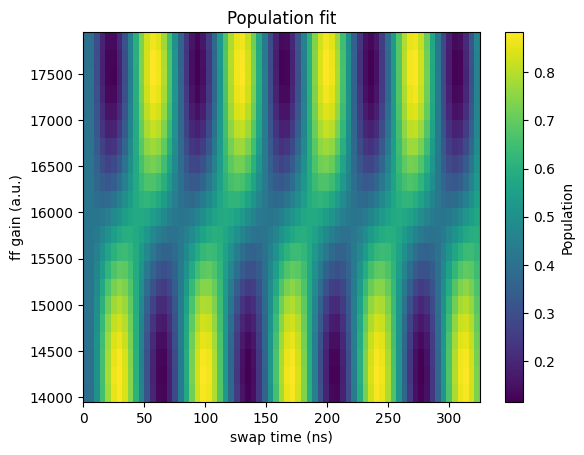

In [22]:


# J, tIdle, mx, my, mz, tOffset = result.x


print(f'purity: {np.sqrt(mx**2 + my**2 + mz**2)}')


function_parameters = simulation_kwargs.copy()

for fit_param in fit_params:
    function_parameters[fit_param] = result.x[fit_params.index(fit_param)]

J = function_parameters['J']
tIdle = function_parameters['tIdle']
mx = function_parameters['mx']
my = function_parameters['my']
mz = function_parameters['mz']
tOffset = function_parameters['tOffset']
frequency_per_gain = function_parameters['frequency_per_gain']

fit_ff_gains = np.linspace(ff_gains[0], ff_gains[-1], 101)
fit_ff_gains = measurement.get_ff_gains()
fit_t_swaps = t_swaps

population_fit = np.zeros((len(fit_ff_gains), len(fit_t_swaps)))

print(function_parameters)

for i in range(len(fit_ff_gains)):
    function_parameters['gain'] = fit_ff_gains[i] - gain_start
    for j in range(len(fit_t_swaps)):
        function_parameters['tSwap'] = fit_t_swaps[j]
        population_fit[i, j] = f_gain(**function_parameters).real[0, 0]



plt.imshow(population_fit, aspect='auto', origin='lower', interpolation='none',
           extent=[fit_t_swaps[0], fit_t_swaps[-1], fit_ff_gains[0], fit_ff_gains[-1]])
plt.colorbar(label='Population')
plt.xlabel('swap time (ns)')
plt.ylabel('ff gain (a.u.)')
plt.title('Population fit')


# for i in range(5):
#     plt.axhline(gain_start + i*gain_period, linestyle=':', color='red')



plt.show()

In [169]:
population_data = measurement.get_population_corrected()[state_to_readout_indices[state]]

residuals = np.power(population_data - population_fit, 2)


plt.imshow(residuals, aspect='auto', origin='lower', interpolation='none',
           extent=[t_swaps[0], t_swaps[-1], ff_gains[0], ff_gains[-1]])
plt.colorbar(label='Population')
plt.xlabel('swap time (ns)')
plt.ylabel('ff gain (a.u.)')
plt.title('Residuals')


plt.show()

ValueError: operands could not be broadcast together with shapes (21,71) (101,71) 

In [24]:
# use fit parameters to find gain point that gives the minimum contrast

# omegas = (ff_gains - 2475) / dac_per_GHz *2*np.pi # GHz

# 2*np.pi * omegas * tIdle = 0

frequency_period = 2*np.pi/tIdle
print(f'frequency_period: {frequency_period}')
minimum_contrast_frequency = 0

gain_period = frequency_period / frequency_per_gain
print(f'gain period = {gain_period}')

minimum_contrast_gain = gain_start

while minimum_contrast_gain < ff_gains[0]:
    minimum_contrast_gain += gain_period
while minimum_contrast_gain > ff_gains[-1]:
    minimum_contrast_gain -= gain_period

print(f'minimum_contrast_gain: {minimum_contrast_gain}')



frequency_period: 0.939920331599676
gain period = 6173.064794081762
minimum_contrast_gain: 14926.129588163523


{'J': 0.04366152021210902, 'tIdle': 6.684806249999999, 'mx': 0.6853338821775627, 'my': -0.30115247447058957, 'mz': -0.1729805469608589, 'tOffset': 0.6990110391392378, 'frequency_per_gain': 0.00015226153668446767, 'tSwap': 325.52099999999996, 'gain': 15371.0}


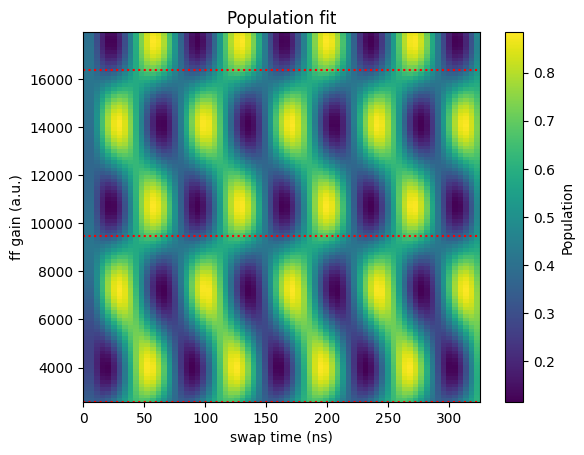

In [32]:

fit_ff_gains = np.linspace(gain_start, ff_gains[-1], 101)
fit_t_swaps = t_swaps

population_fit = np.zeros((len(fit_ff_gains), len(fit_t_swaps)))

print(function_parameters)

for i in range(len(fit_ff_gains)):
    function_parameters['gain'] = fit_ff_gains[i] - gain_start
    for j in range(len(fit_t_swaps)):
        function_parameters['tSwap'] = fit_t_swaps[j]
        population_fit[i, j] = f_gain(**function_parameters).real[0, 0]



plt.imshow(population_fit, aspect='auto', origin='lower', interpolation='none',
           extent=[fit_t_swaps[0], fit_t_swaps[-1], fit_ff_gains[0], fit_ff_gains[-1]])
plt.colorbar(label='Population')
plt.xlabel('swap time (ns)')
plt.ylabel('ff gain (a.u.)')
plt.title('Population fit')


for i in range(3):
    plt.axhline(gain_start + i*gain_period, linestyle=':', color='red')



plt.show()

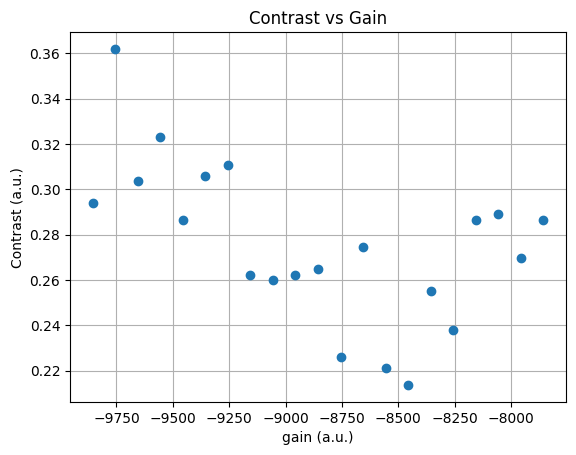

In [170]:
contrasts = np.zeros(len(ff_gains))

for i in range(len(ff_gains)):
    contrasts[i] = np.max(population_data[i]) - np.min(population_data[i])


plt.plot(ff_gains, contrasts, marker='o', linestyle='')
plt.xlabel('gain (a.u.)')
plt.ylabel('Contrast (a.u.)')
plt.title('Contrast vs Gain')
plt.grid()
plt.show()


In [152]:
def contrast_function(gain, tIdle, amp, frequency_factor, phi, d, vertical_offset=0):
    sin_term = np.power(np.sin(gain*tIdle*2*np.pi*frequency_factor + phi), 2)
    cos_term = np.power(np.cos(gain*tIdle*2*np.pi*frequency_factor + phi), 2)
    return amp*np.sqrt(sin_term + (d**2)*cos_term) + vertical_offset


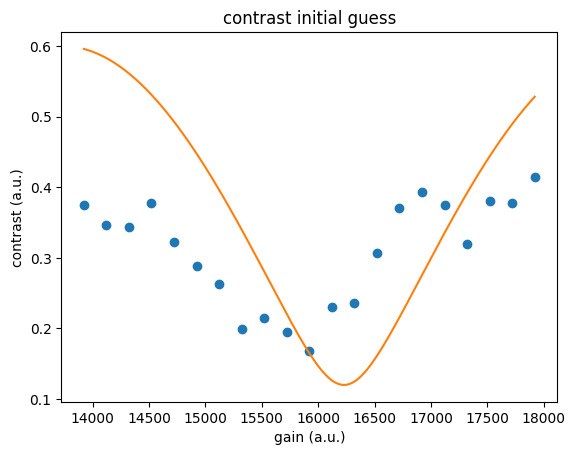

In [163]:

fit_gains = np.linspace(ff_gains[0], ff_gains[-1], 1001)

if state == 'double_jump_gain_sweep':
    frequency_factor = 1.5e-5
    phi = -0.8
    amp = 0.6
    vertical_offset = 0
    d = 0.2
elif state == 'double_jump_gain_sweep2':
    frequency_factor = 3e-5
    phi = 1.5
    amp = 0.7
    vertical_offset = 0
    d = 0.6

initial_guess = [amp, frequency_factor, phi, d, vertical_offset]

bounds = ([0, 0, 0, -1, -np.inf], [1, np.inf, np.pi, 1, np.inf])

contrasts_guess = contrast_function(fit_gains, tIdle, *initial_guess)

contrast_fit_function = lambda x, amp, frequency_factor, phi, d, vertical_offset: contrast_function(x, tIdle, amp, frequency_factor, phi, d, vertical_offset)

plt.plot(ff_gains, contrasts, linestyle='', marker='o', label='data')
plt.plot(fit_gains, contrast_fit_function(fit_gains, *initial_guess), label='initial guess')
plt.xlabel('gain (a.u.)')
plt.title('contrast initial guess')
plt.ylabel('contrast (a.u.)')
plt.show()

In [164]:
popt, perr = curve_fit(contrast_fit_function, ff_gains, contrasts, p0=initial_guess)
print(popt)

[ 2.50869232e-01  1.97281767e-05 -3.58638089e+00  1.82477081e-01
  1.35370467e-01]


ff_gain 0: 13921.0
ff_gain -1: 17921.0
first gain: 4328.134726556866
gain period: 7582.706173239482
11910.840899796349
19493.547073035832
11910.840899796349
11910.840899796349
minimum contrast gain defaulted to: 15701.0


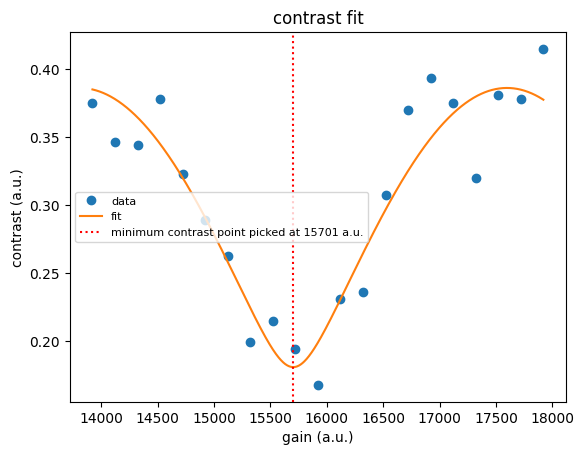

In [166]:
amp_fit, frequency_factor_fit, phi_fit, d, vertical_offset_fit = popt



# gain*tIdle*2*np.pi*frequency_factor + phi = 0

# Find n such that minimum_contrast_gain is within the range of ff_gains
# n_min = int(np.ceil(((ff_gains[0] * tIdle * 2 * np.pi * frequency_factor_fit + phi_fit) / (2 * np.pi))))
# n_max = int(np.floor(((ff_gains[-1] * tIdle * 2 * np.pi * frequency_factor_fit + phi_fit) / (2 * np.pi))))

# print(f'n_min: {n_min}, n_max: {n_max}')

# minimum_contrast_gain = None
# minimum_contrast_n = None

# for n in range(min(n_min, n_max), min(n_min, n_max) + 1):
#     gain = (2 * np.pi * n - phi_fit) / (tIdle * 2 * np.pi * frequency_factor_fit)
#     print(gain)
#     if ff_gains[0] <= gain <= ff_gains[-1]:
#         minimum_contrast_gain = gain
#         minimum_contrast_n = n
#         break

# if minimum_contrast_gain is not None:
#     print(f"Minimum contrast gain: {round(minimum_contrast_gain)}, n: {minimum_contrast_n}")
# else:
#     print("No solution for minimum contrast gain within the gain range.")


gain = -phi_fit / (tIdle * 2 * np.pi * frequency_factor_fit)

gain_period = 1/(tIdle * frequency_factor_fit)

print(f'ff_gain 0: {ff_gains[0]}')
print(f'ff_gain -1: {ff_gains[-1]}')

print(f'first gain: {gain}')
print(f'gain period: {gain_period}')
minimum_contrast_gain = gain
while minimum_contrast_gain < ff_gains[0]:
    minimum_contrast_gain += gain_period
    print(minimum_contrast_gain)
while minimum_contrast_gain > ff_gains[-1]:
    minimum_contrast_gain -= gain_period
    print(minimum_contrast_gain)

print(minimum_contrast_gain)

if not (ff_gains[0] <= minimum_contrast_gain <= ff_gains[-1]):
    minimum_contrast_gain = None


plt.plot(ff_gains, contrasts, linestyle='', marker='o', label='data')
plt.plot(fit_gains, contrast_fit_function(fit_gains, *popt), label='fit')


if minimum_contrast_gain is None:
    minimum_contrast_gain = fit_gains[np.argmin(contrast_fit_function(fit_gains, *popt))]
    print(f'minimum contrast gain defaulted to: {minimum_contrast_gain}')
if minimum_contrast_gain is not None:
    plt.axvline(minimum_contrast_gain, label=f'minimum contrast point picked at {round(minimum_contrast_gain)} a.u.', linestyle=':', color='red')

plt.legend(fontsize=8, loc='center left')

plt.xlabel('gain (a.u.)')
plt.title('contrast fit')
plt.ylabel('contrast (a.u.)')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: type NoneType doesn't define __round__ method

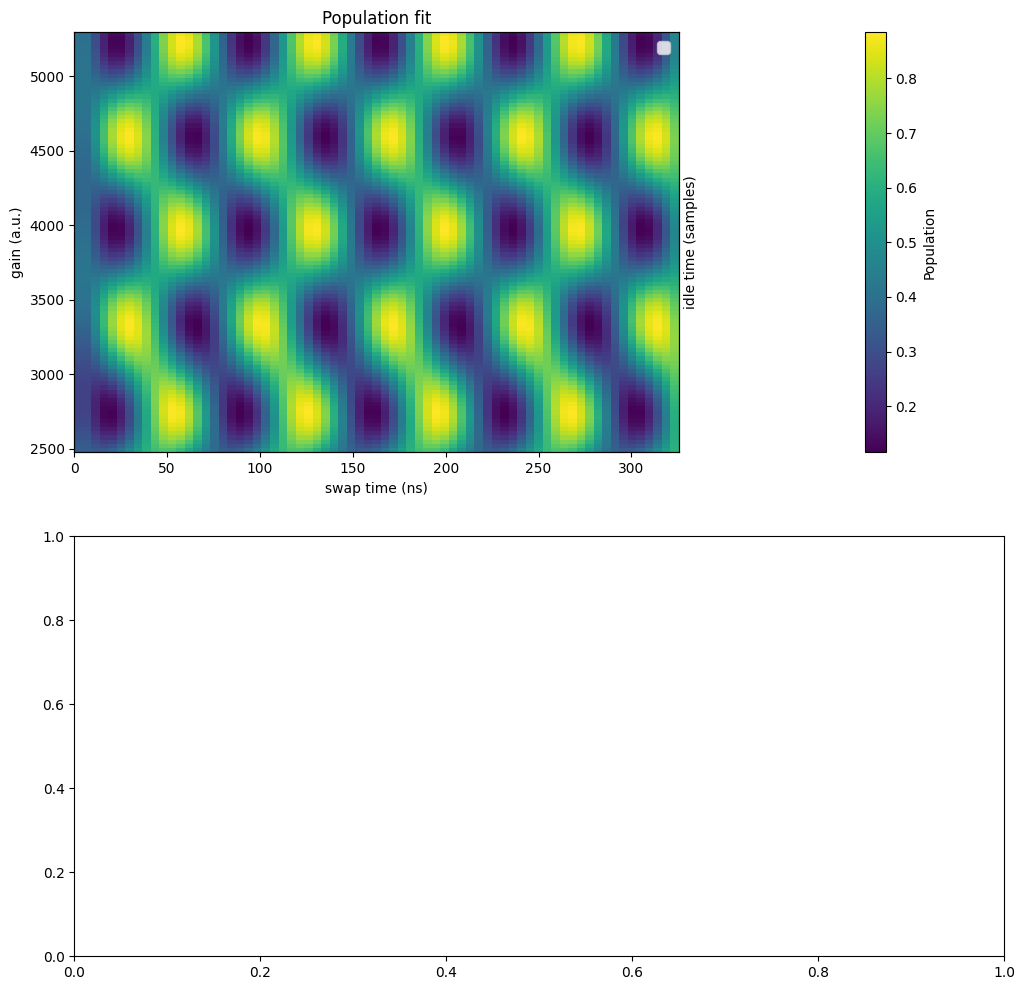

In [135]:
### fit and residuals

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot population fit
im1 = ax1.imshow(population_fit, aspect='auto', origin='lower', interpolation='none',
                 extent=[t_swaps[0], t_swaps[-1], gain_start, ff_gains[-1]])

                


pad = 0.2
cbar1 = plt.colorbar(im1, ax=ax1, label='Population', pad=pad)

ax1.set_xlabel('swap time (ns)')
ax1.set_ylabel('gain (a.u.)')
ax1.set_title('Population fit')

# ax1.axhline(total_offset_time, linestyle=':', color='red', label=f'minimum contrast point picked at {int(total_offset_time_samples)} samples, {total_offset_time:.2f} ns')
ax1.legend(fontsize=12)

# Add secondary y-axis for ax1 with sample labels
ax1_twin = ax1.twinx()
max_samples = abs(convert_ns_to_samples(np.max(t_idles)))
tick_labels = np.arange(-max_samples, max_samples + 1, 5)
tick_locations = [convert_samples_to_ns(label) for label in tick_labels]
ax1_twin.set_yticks(tick_locations)
ax1_twin.set_yticklabels([int(label) for label in tick_labels])
ax1_twin.set_ylabel('idle time (samples)')
ax1_twin.set_ylim(ax1.get_ylim())

ax1.axhline(minimum_contrast_gain, label=f'minimum contrast point picked at {round(minimum_contrast_gain)} a.u.', linestyle=':', color='red')
ax1.legend(fontsize=12)

# Plot residuals
im2 = ax2.imshow(residuals, aspect='auto', origin='lower', interpolation='none',
                 extent=[t_swaps[0], t_swaps[-1], ff_gains[0], ff_gains[-1]])
cbar2 = plt.colorbar(im2, ax=ax2, label='Residuals', pad=pad)
ax2.set_xlabel('swap time (ns)')
ax2.set_ylabel('gain (a.u.)')
ax2.set_title('Residuals')

# Add secondary y-axis for ax2 with sample labels
ax2_twin = ax2.twinx()
ax2_twin.set_yticks(tick_locations)
ax2_twin.set_yticklabels([int(label) for label in tick_labels])
ax2_twin.set_ylabel('idle time (samples)')
ax2_twin.set_ylim(ax2.get_ylim())

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


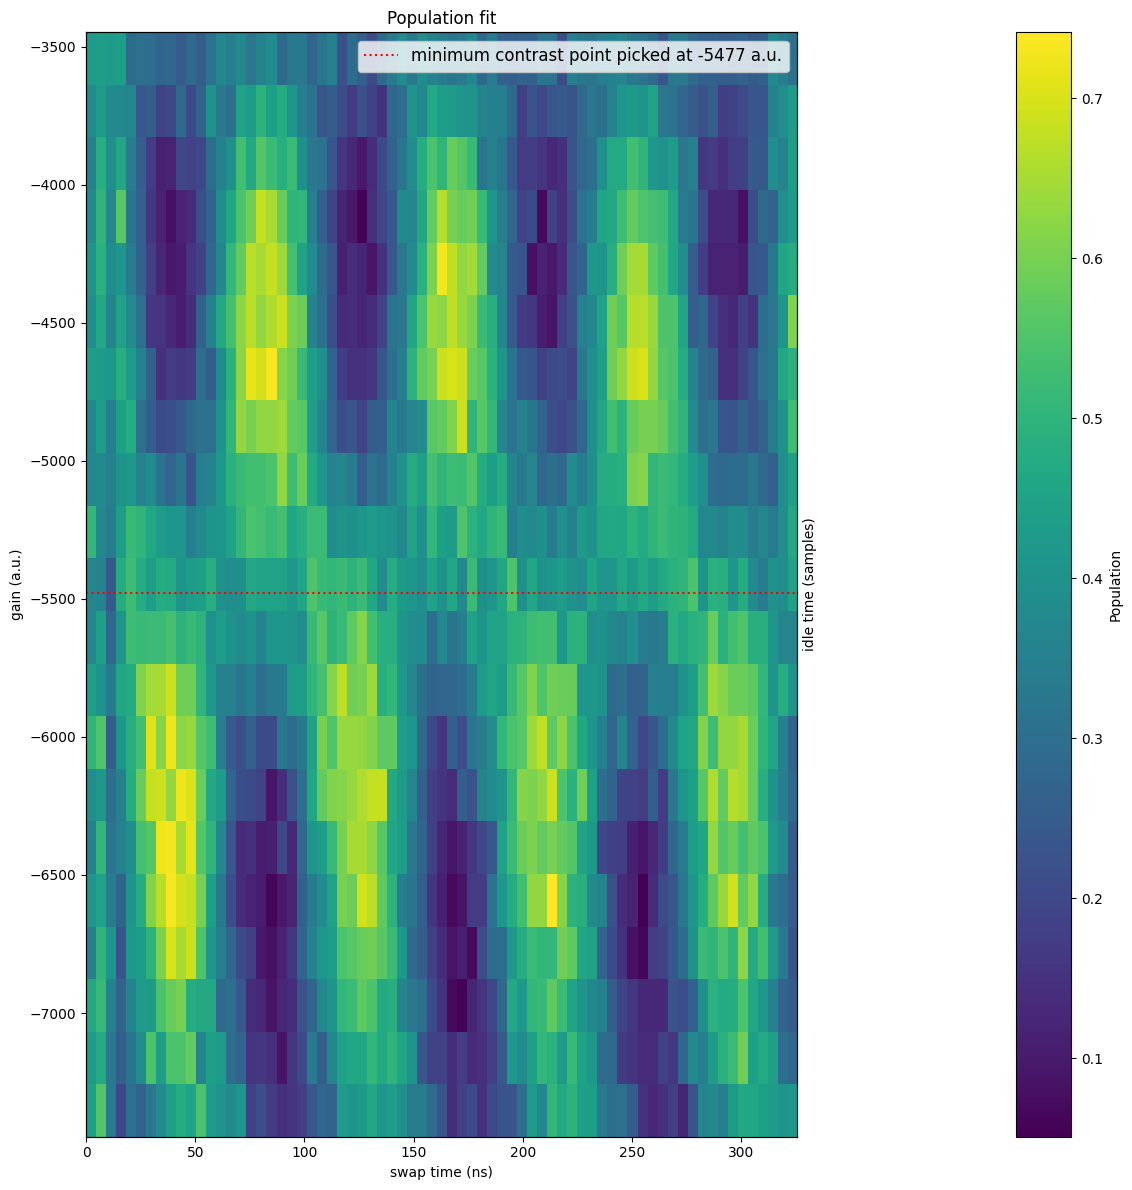

In [110]:
### data with minimum contrast pont

# Create figure with two subplots
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))

# Plot population fit
im1 = ax1.imshow(population_data, aspect='auto', origin='lower', interpolation='none',
                 extent=[t_swaps[0], t_swaps[-1], ff_gains[0], ff_gains[-1]])

                


pad = 0.2
cbar1 = plt.colorbar(im1, ax=ax1, label='Population', pad=pad)

ax1.set_xlabel('swap time (ns)')
ax1.set_ylabel('gain (a.u.)')
ax1.set_title('Population fit')

# ax1.axhline(total_offset_time, linestyle=':', color='red', label=f'minimum contrast point picked at {int(total_offset_time_samples)} samples, {total_offset_time:.2f} ns')
ax1.legend(fontsize=12)

# Add secondary y-axis for ax1 with sample labels
ax1_twin = ax1.twinx()
max_samples = abs(convert_ns_to_samples(np.max(t_idles)))
tick_labels = np.arange(-max_samples, max_samples + 1, 5)
tick_locations = [convert_samples_to_ns(label) for label in tick_labels]
ax1_twin.set_yticks(tick_locations)
ax1_twin.set_yticklabels([int(label) for label in tick_labels])
ax1_twin.set_ylabel('idle time (samples)')
ax1_twin.set_ylim(ax1.get_ylim())

ax1.axhline(minimum_contrast_gain, label=f'minimum contrast point picked at {round(minimum_contrast_gain)} a.u.', linestyle=':', color='red')
ax1.legend(fontsize=12)

plt.tight_layout()
plt.show()